In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from defaults.plot import *

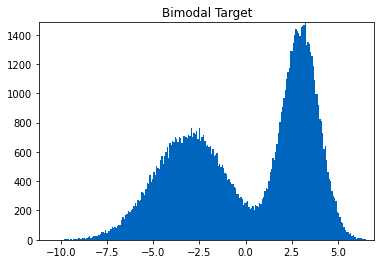

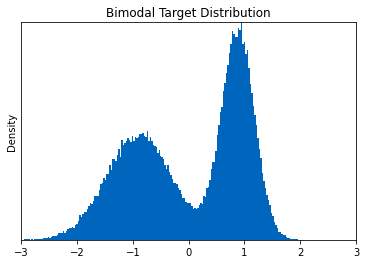

In [2]:
import torch
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import flows.utils as utils
from sklearn.preprocessing import StandardScaler

dist_x1 = dist.Normal(torch.tensor([-3.0]), torch.tensor([2.0]))
dist_x2 = dist.Normal(torch.tensor([3.0]), torch.tensor([1.0]))

X_bimodal = np.concatenate([dist_x1.sample([50000]).numpy(), dist_x2.sample([50000]).numpy()])

plt.hist(X_bimodal, bins=250)
plt.title('Bimodal Target')
plt.show()

X_bimodal = StandardScaler().fit_transform(X_bimodal)
# We center it, so learning is easier

plt.title('Bimodal Target Distribution')
plt.hist(X_bimodal, bins=200, density=True)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/bimodal.pdf", dpi=dpi)
plt.show()

In [3]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_bimodal = T.Spline(1, count_bins=16)
flow_dist_bimodal = dist.TransformedDistribution(base_dist, [spline_transform_bimodal])

steps = 1001
dataset = torch.tensor(X_bimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_bimodal.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_bimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_bimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.6426637172698975
step: 200, loss: 1.1877161264419556
step: 400, loss: 1.18086838722229
step: 600, loss: 1.1791377067565918
step: 800, loss: 1.17814040184021
step: 1000, loss: 1.1774981021881104
Wall time: 1min 3s


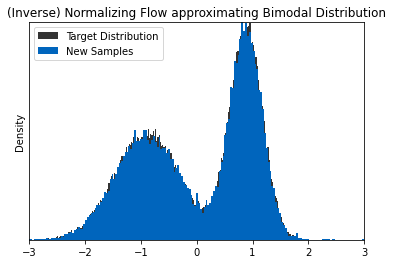

In [4]:
plt.title('(Inverse) Normalizing Flow approximating Bimodal Distribution')
plt.hist(X_bimodal, bins=250, density=True, label='Target Distribution', color=TUMDarkGray)
plt.hist(flow_dist_bimodal.sample(torch.Size([50000])).detach().numpy(), bins=250, density=True, label='New Samples', color=TUMBlue)
plt.legend()
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/bimodal-sampled.pdf", dpi=dpi)
plt.show()

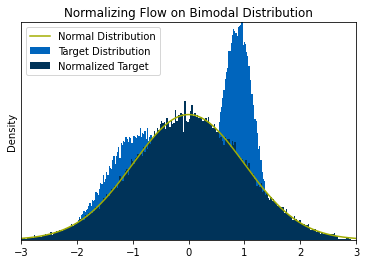

In [5]:
import scipy.stats as stats
import math

plt.title('Normalizing Flow on Bimodal Distribution')
plt.hist(X_bimodal, bins=250, density=True, label='Target Distribution', color=TUMBlue)
plt.hist(spline_transform_bimodal.inv(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label='Normalized Target', color=TUMSecondaryBlue2)

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(-3, 3, 250)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)

plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)

plt.legend()
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.savefig("figures/nfs/bimodal-nf.pdf", dpi=dpi)
plt.show()

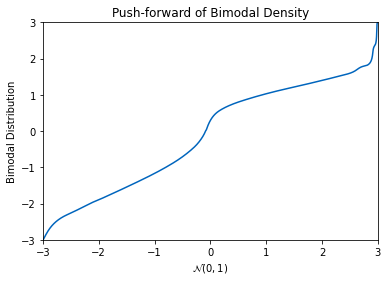

In [6]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy()

plt.title("Push-forward of Bimodal Density")
plt.plot(input, mapped, color=TUMBlue)

plt.xlabel(r"$\mathcal{N}(0,1)$")
plt.ylabel("Bimodal Distribution")
plt.xlim(-3, 3)

plt.savefig("figures/nfs/bimodal-pushforward.pdf", dpi=dpi)
plt.show()
#print(mapped[5000])

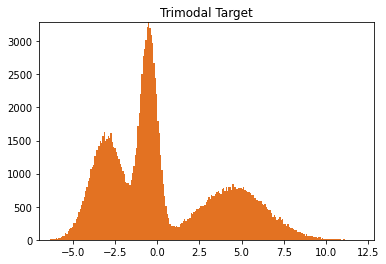

In [7]:
dist_x1 = dist.Normal(torch.tensor([-3.0]), torch.tensor([1.0]))
dist_x2 = dist.Normal(torch.tensor([4.5]), torch.tensor([2.0]))
dist_x3 = dist.Normal(torch.tensor([-0.5]), torch.tensor([0.5]))

X_trimodal = np.concatenate([dist_x1.sample([50000]).numpy(), dist_x2.sample([50000]).numpy(), dist_x3.sample([50000]).numpy()])

plt.hist(X_trimodal, bins=250, color=TUMAccentOrange)
plt.title('Trimodal Target')
plt.show()

X_trimodal = StandardScaler().fit_transform(X_trimodal)

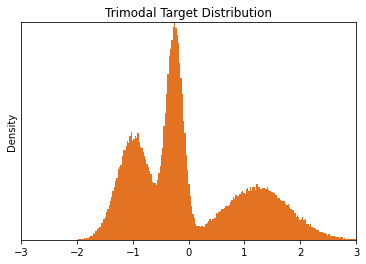

In [8]:
plt.title('Trimodal Target Distribution')
plt.hist(X_trimodal, bins=250, color=TUMAccentOrange)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/trimodal.pdf", dpi=dpi)
plt.show()

In [9]:
%%time

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
#base_dist = dist.Uniform(-100, 100.0)
spline_transform_trimodal = T.Spline(1, count_bins=26) # TODO: we need more bins for trimodal, to better approximate it
flow_dist_trimodal = dist.TransformedDistribution(base_dist, [spline_transform_trimodal])

steps = 1001
dataset = torch.tensor(X_trimodal, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform_trimodal.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_trimodal.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_trimodal.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.748599052429199
step: 200, loss: 1.1996108293533325
step: 400, loss: 1.181381344795227
step: 600, loss: 1.1774606704711914
step: 800, loss: 1.1757335662841797
step: 1000, loss: 1.174644947052002
Wall time: 2min 28s


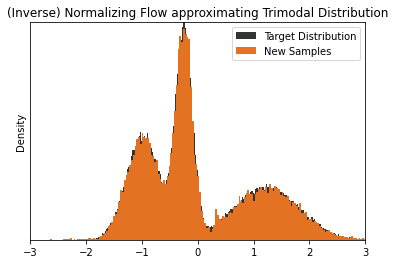

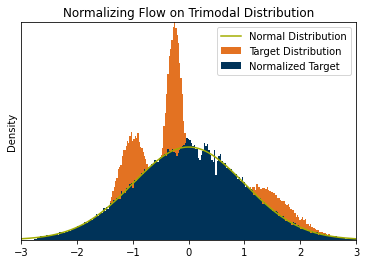

In [10]:
plt.title('(Inverse) Normalizing Flow approximating Trimodal Distribution')
plt.hist(X_trimodal, bins=250, density=True, label='Target Distribution', color=TUMDarkGray)
plt.hist(flow_dist_trimodal.sample(torch.Size([50000])).detach().numpy(), bins=250, density=True, label='New Samples', color=TUMAccentOrange)
plt.legend()
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/trimodal-sampled.pdf", dpi=dpi)
plt.show()

plt.title('Normalizing Flow on Trimodal Distribution')
plt.hist(X_trimodal, bins=250, density=True, label='Target Distribution', color=TUMAccentOrange)
plt.hist(spline_transform_trimodal.inv(torch.tensor(X_trimodal)).detach().numpy(), bins=250, density=True, label='Normalized Target', color=TUMSecondaryBlue2)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
plt.legend()
plt.savefig("figures/nfs/trimodal-nf.pdf", dpi=dpi)
plt.show()

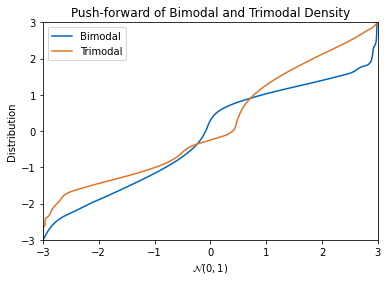

In [11]:
input = np.linspace(-3, 3, 10000)

plt.title("Push-forward of Bimodal and Trimodal Density")
plt.plot(input, spline_transform_bimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "Bimodal", color=TUMBlue)
plt.plot(input, spline_transform_trimodal(torch.tensor([[x] for x in input])).detach().numpy(), label = "Trimodal", color=TUMAccentOrange)
plt.xlabel(r"$\mathcal{N}(0,1)$")
plt.ylabel("Distribution")
plt.xlim(-3, 3)
#no_axis(x=True)
plt.legend()

plt.savefig("figures/nfs/bimodal-and-trimodal-pushforward.pdf", dpi=dpi)
plt.show()

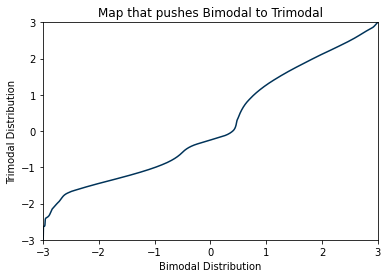

In [12]:
input = np.linspace(-3, 3, 10000)
mapped = spline_transform_bimodal.inv(torch.tensor([[x] for x in input]))
mapped = spline_transform_trimodal(torch.tensor([[x] for x in input]))

plt.title("Map that pushes Bimodal to Trimodal")
plt.plot(input, mapped.detach().numpy(), color=TUMSecondaryBlue2)
plt.xlabel(r"Bimodal Distribution")
plt.ylabel(r"Trimodal Distribution")
plt.xlim(-3, 3)
plt.savefig("figures/nfs/bimodal-to-trimodal-pushforward.pdf", dpi=dpi)
plt.show()

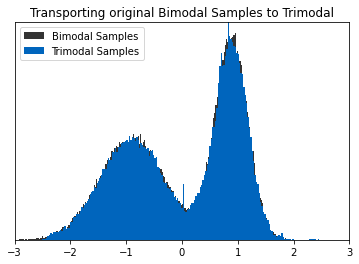

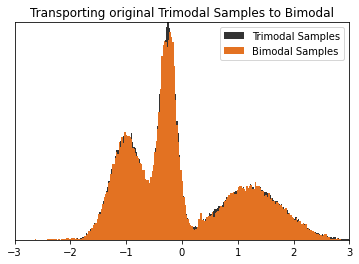

In [13]:

plt.title("Transporting original Bimodal Samples to Trimodal")
plt.hist(X_bimodal, bins=250, density=True, label='Bimodal Samples', color=TUMDarkGray)
plt.hist(spline_transform_bimodal(spline_transform_trimodal.inv(torch.tensor(X_trimodal))).detach().numpy(), bins=250, density=True, label="Trimodal Samples", color=TUMBlue)
plt.legend()
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/bimodal-to-trimodal.pdf", dpi=dpi)
plt.show()

plt.title("Transporting original Trimodal Samples to Bimodal")
plt.hist(X_trimodal, bins=250, density=True, label='Trimodal Samples', color=TUMDarkGray)
plt.hist(spline_transform_trimodal(spline_transform_bimodal.inv(torch.tensor(X_bimodal))).detach().numpy(), bins=250, density=True, label="Bimodal Samples", color=TUMAccentOrange)
plt.legend()
plt.xlim(-3, 3)
no_axis(x=True)
plt.savefig("figures/nfs/trimodal-to-bimodal.pdf", dpi=dpi)
plt.show()


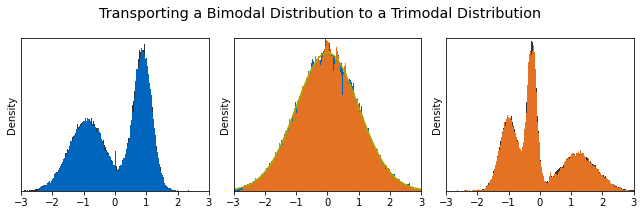

In [14]:
# Nothing new but create a nice figure

from matplotlib.patches import Patch

plt.subplots(1, 3, figsize=(9, 3))
plt.gcf().suptitle("Transporting a Bimodal Distribution to a Trimodal Distribution", fontsize="x-large")

#TODO legends=
#plt.gca().legend(handles = [Patch(facecolor=TUMBlue, label='Color Patch')], loc="lower center")

plt.subplot(1, 3, 1, aspect='auto')
#plt.title('Bimodal Target Distribution', y=-0.01)
plt.hist(X_bimodal, bins=200, density=True, color=TUMDarkGray)
plt.hist(spline_transform_bimodal(spline_transform_trimodal.inv(torch.tensor(X_trimodal))).detach().numpy(), bins=250, density=True, label="Trimodal Samples", color=TUMBlue)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)

plt.subplot(1, 3, 2, aspect='auto')
#plt.title('Normalized Data', y=-0.01)
plt.hist(spline_transform_bimodal.inv(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label='Normalized Bimodal', color=TUMBlue)
plt.hist(spline_transform_trimodal.inv(torch.tensor(X_trimodal)).detach().numpy(), bins=250, density=True, label='Normalized Trimodal', color=TUMAccentOrange)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normal Distribution", color=TUMAccentGreen)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)
#plt.legend()

plt.subplot(1, 3, 3, aspect='auto')
#plt.title('Trimodal Target Distribution',y=-0.01)
plt.hist(X_trimodal, bins=250, color=TUMDarkGray, density=True)
plt.hist(spline_transform_trimodal(spline_transform_bimodal.inv(torch.tensor(X_bimodal))).detach().numpy(), bins=250, density=True, color=TUMAccentOrange)
plt.ylabel("Density")
plt.xlim(-3, 3)
no_axis(x=True)

plt.tight_layout()
plt.savefig("figures/nfs/bimodal-to-trimodal-explained.pdf", dpi=dpi)
plt.show()

In [ ]:
# Now the same but with the utils function
bimodal_to_trimodal = utils.samples_to_samples(X_bimodal, X_trimodal)

plt.hist(X_trimodal, bins=250, density=True, label='The original trimodal sampled data (i.e. target)')
plt.hist(bimodal_to_trimodal(torch.tensor(X_bimodal)).detach().numpy(), bins=250, density=True, label="The original bimodal sampled points transported via a normal distribution to a trimodal distribution")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

step: 0, loss: 2.5195729732513428
step: 200, loss: 1.1975986957550049
step: 400, loss: 1.1825804710388184
step: 600, loss: 1.1791963577270508
step: 800, loss: 1.1779544353485107
